# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1.  ANDRIANJOHANY Liantsoa Nomban'Ny Avo                   IGGLIA 4 Numéro 35
2.  ANDRIANANDRASANA Finiaina                              IGGLIA 4 Numéro 36
3.  RAHARINAIVO Faramampionna                              IGGLIA 4 Numéro 42
4.  RAKOTOMALALA Aina Anjaratiana                          IGGLIA 4 Numéro 54
5.  FERANAH Léa Thérèse                                    IGGLIA 4 Numéro 48
6.  SITRAKINIAVO Harenjanahary Sarobidy                    IGGLIA 4 Numéro 52


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

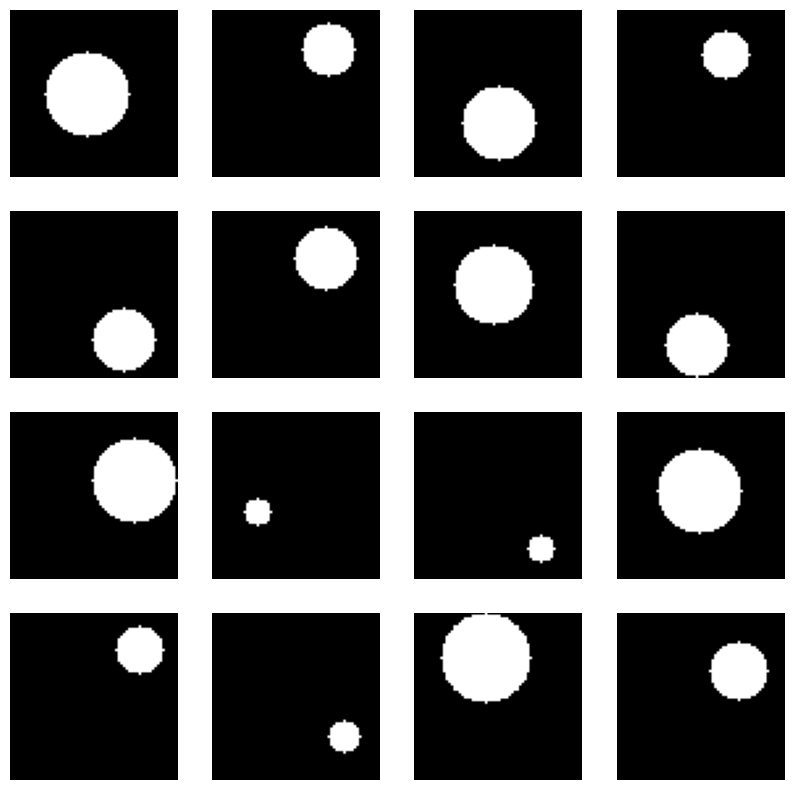

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [ ]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [6]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.4729 - val_loss: 0.2239
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1921 - val_loss: 0.1399
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1334 - val_loss: 0.1123
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1078 - val_loss: 0.0970
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0940 - val_loss: 0.0876
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0859 - val_loss: 0.0824
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0793 - val_loss: 0.0782
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0760 - val_loss: 0.0761
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0735 - val_loss: 0.0748
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0708 - val_loss: 0.0722
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0694 - val_loss: 0.0705
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0670 - val_l

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


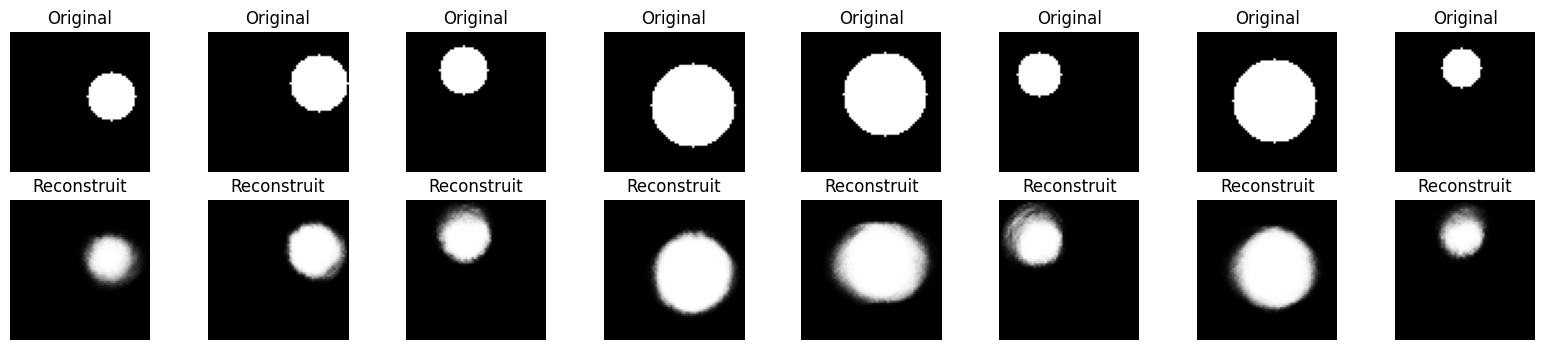

In [7]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [ ]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [11]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - loss: 0.5359 - val_loss: 0.3153
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.3052 - val_loss: 0.2552
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2174 - val_loss: 0.1202
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1055 - val_loss: 0.0826
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0754 - val_loss: 0.0598
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0532 - val_loss: 0.0413
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0384 - val_loss: 0.0332
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0320 - val_loss: 0.0292
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0277 - val_loss: 0.0291
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0273 - val_loss: 0.0230
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0220 - val_loss: 0.0220
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


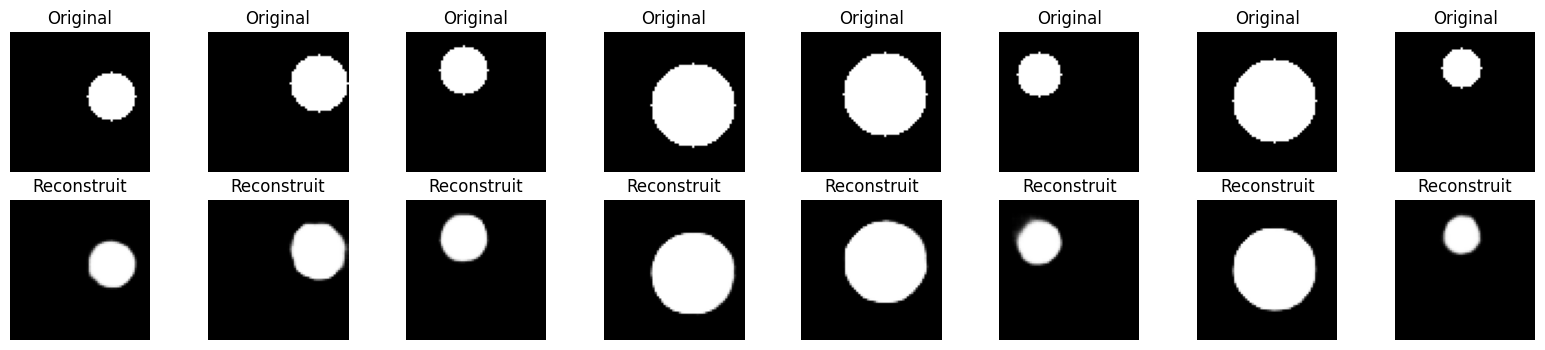

In [12]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

# 1-Testons les deux modeles sur des images imparfaites

### a - Testons le Model FCN sur des images d'entrées imparfaites avec le bruit gaussian

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


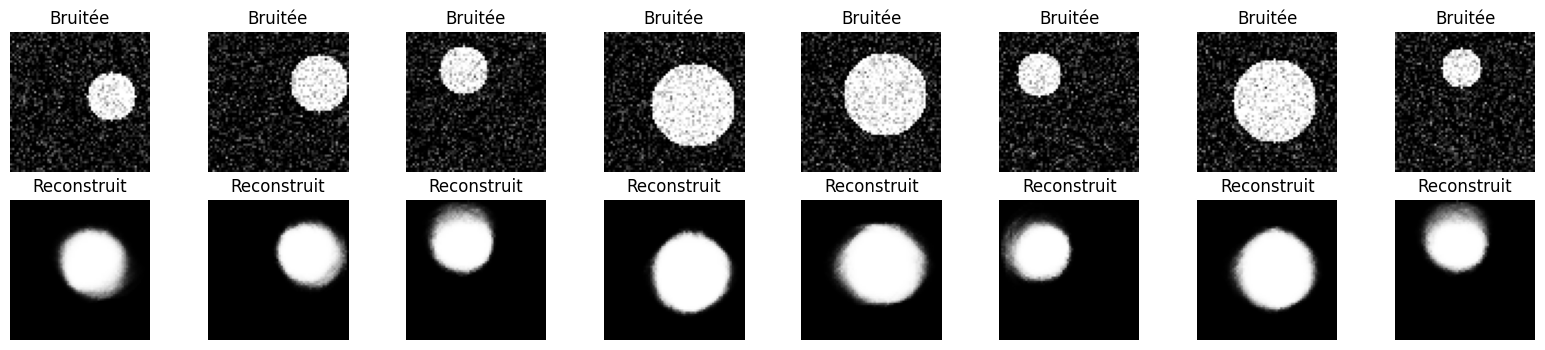

In [8]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    """Ajoute du bruit gaussien aux images."""
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = np.clip(images + noise, 0.0, 1.0)  # On s'assure que les valeurs restent entre 0 et 1
    return noisy_images

# Ajouter du bruit gaussien à test_data
noisy_test_data = add_gaussian_noise(test_data, mean=0.0, std=0.2)  # On peut ajuster le niveau de bruit (std)

# Tester le modèle avec les images bruitées
decoded_imgs_noisy_fc = autoencoder_fc.predict(noisy_test_data)

# Afficher quelques résultats
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale (bruitée)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_data[i].squeeze(), cmap='gray')
    plt.title('Bruitée')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_noisy_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

INTERPRETATION
Les images bruités sont avec du bruit aléatoire dégradant la qualité des cercles visibles. Les images reconstruites sont avec une réduction du bruit permettant de mieux distinguer les formes. La reconstruction améliore la clarté mais peut lisser certains détails.

### b - Testons le Model Convolutionnel sur des images d'entrées imparfaites avec le bruit gaussian

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


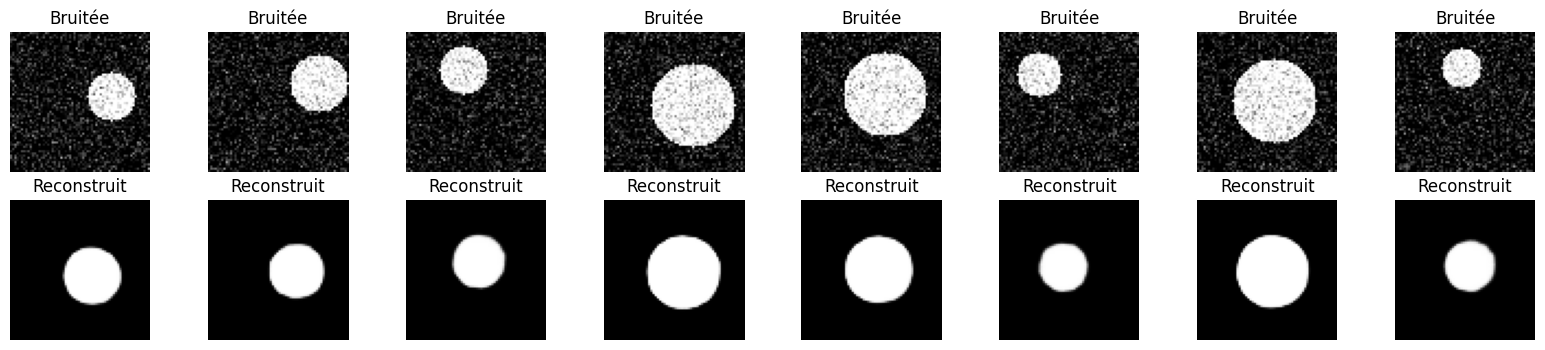

In [ ]:
# Ajouter du bruit gaussien à test_data
noisy_test_data = add_gaussian_noise(test_data, mean=0.0, std=0.2)  # On peut ajuster le niveau de bruit (std)

# Tester le modèle avec les images bruitées
decoded_imgs_noisy_conv = autoencoder_conv.predict(noisy_test_data)

# Afficher quelques résultats
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale (bruitée)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_data[i].squeeze(), cmap='gray')
    plt.title('Bruitée')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_noisy_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

INTERPRETATION
Les images bruités sont avec du bruit aléatoire dégradant la qualité des cercles visibles. Les images reconstruites sont avec une réduction du bruit permettant d'afficher clairement la forme des cercles

# 2-Améliorations du modèle Convolutif :

Dropout : Ajouté pour prévenir le surapprentissage et améliorer la généralisation.

Plus de filtres en convolution : Augmenté pour capturer plus de détails.

LeakyReLU : Remplacement de ReLU pour éviter les neurones morts.

Activation sigmoid : Utilisée dans la couche finale pour normaliser les sorties entre 0 et 1.

BatchNormalization : Ajoutée pour accélérer l'entraînement et stabiliser les gradients.

In [1]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Dropout(0.3)(x)  # Dropout ajouté pour la régularisation
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)  # Normalisation par lot
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)  # Normalisation par lot
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv_improved = models.Model(input_img, decoded)

autoencoder_conv_improved.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv_improved.summary()


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
history_conv = autoencoder_conv_improved.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0158 - val_loss: 0.0143
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0172 - val_loss: 0.0112
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0166 - val_loss: 0.0352
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0206 - val_loss: 0.0131
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0156 - val_loss: 0.0413
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0180 - val_loss: 0.0147
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0145 - val_loss: 0.0128
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0159 - val_loss: 0.0145
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0170 - val_loss: 0.0249
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0154 - val_loss: 0.0117
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0154 - val_loss: 0.0207
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


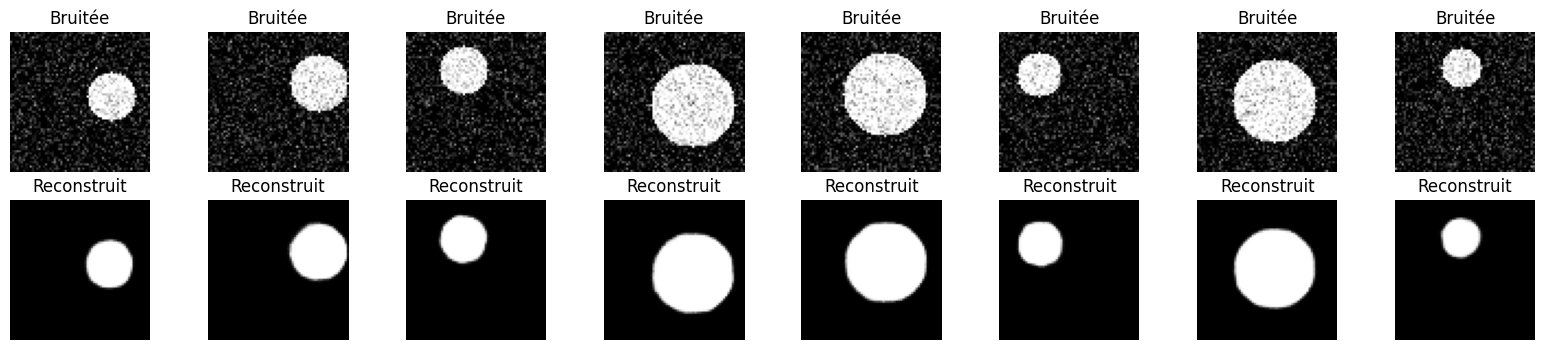

In [26]:
# Ajouter du bruit gaussien à test_data
noisy_test_data = add_gaussian_noise(test_data, mean=0.0, std=0.2)  # On peut ajuster le niveau de bruit (std)

# Tester le modèle avec les images bruitées
decoded_imgs_noisy_conv = autoencoder_conv_improved.predict(noisy_test_data)

# Afficher quelques résultats
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale (bruitée)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_data[i].squeeze(), cmap='gray')
    plt.title('Bruitée')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_noisy_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit (Amélioré)')
    plt.axis('off')
plt.show()

### 3- Réponse : Dimension de l'espace latent pour les cercles
Non, il n'est pas necessaire d'augmenter la taille de l'espace latent  pour avoir un reseau car garder un espace latent de dimension 3 (la dimension actuel ) nous permet d'avoir :  
- **Une simplicité des données** : Les cercles sont définis par 3 paramètres (x, y, rayon).  
- **Performance validée** : La faible perte (≈0.06) montre que le modèle apprend bien avec 3 dimensions.  
- **Efficacité** : Moins de complexité et temps d'entraînement réduit.  
    